In [183]:
import os
from pathlib import Path
from typing import Callable

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from segregation.aspatial import MinMax
import rasterio as rio
from scipy.spatial.distance import cdist


data_dir = Path('../data')

In [184]:
def get_xy(
        geodf: gpd.GeoDataFrame,
        geometry_col: str = None,
) -> gpd.GeoDataFrame:

    if not geometry_col:
        geometry_col = geodf.geometry.name

    if geodf[geometry_col].geom_type[0] == 'Point':
        geodf['x'] = geodf[geometry_col].apply(lambda geom: geom.x)
        geodf['y'] = geodf[geometry_col].apply(lambda geom: geom.y)
    else:
        geodf['x'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[0]))
        geodf['y'] = geodf[geometry_col].apply(lambda geom: tuple(geom.exterior.coords.xy[1]))
    return geodf


def kernel_density_surface(
        data: gpd.GeoDataFrame,
        group: str,
        bandwidth,
        cell_size,
        kernel_function: Callable,
):
    pop = get_xy(data)
    pad = bandwidth * 2

    minx, miny, maxx, maxy = pop.geometry.total_bounds

    minx -= pad
    miny -= pad
    maxx += pad
    maxy += pad

    x = np.arange(minx, maxx, cell_size)
    y = np.arange(miny, maxy, cell_size)

    X, Y = np.meshgrid(x, y)

    xy = np.vstack([Y.ravel(), X.ravel()]).T

    U = cdist(xy, pop[['y', 'x']].values, metric='euclidean')
    W = kernel_function(U, bandwidth=bandwidth)

    density = (W * pop[group].values).sum(axis=1).reshape(X.shape)

    geotiff_meta = {
        'driver': 'GTiff',
        'count': 1,
        'dtype': 'float64',
        'width': len(x),
        'height': len(y),
        'crs': data.crs,
        'transform': rio.transform.from_bounds(
            west=minx,
            east=maxx,
            north=maxy,
            south=miny,
            width=len(x),
            height=len(y),
        )
    }

    return density[::-1, ], geotiff_meta


def get_S(
        data,
        bandwidth,
        cell_size,
        kernel_function,
):
    if data.empty:
        return None

    density_total, _ = kernel_density_surface(
        data,
        group='total',
        bandwidth=bandwidth,
        cell_size=cell_size,
        kernel_function=kernel_function,
    )
    density_orthodox, _ = kernel_density_surface(
        data,
        group='orthodox',
        bandwidth=bandwidth,
        cell_size=cell_size,
        kernel_function=kernel_function,
    )

    density = pd.DataFrame({
            'orthodox': density_orthodox.flatten(),
            'total': density_total.flatten(),
         })
    S = MinMax(density, 'orthodox', 'total')

    return S


In [185]:
def prepare_pop_data(
        population_data: pd.DataFrame,
        num_cols=None,
) -> pd.DataFrame:

    pop_frame = population_data.fillna(value=0)

    if not num_cols:
        num_cols = [
            'total_men',
            'total_women',
            'orthodox',
            'other_christian',
            'other_religion',
        ]

    pop_frame.loc[:, num_cols] = pop_frame.loc[:, num_cols].astype(int)

    pop_frame['lutheran'] = pop_frame['total_men total_women'.split()].sum(axis=1) \
                            - pop_frame['other_christian orthodox other_religion'.split()].sum(axis=1)

    pop_frame['total'] = pop_frame['other_christian orthodox other_religion lutheran'.split()].sum(axis=1)

    return pop_frame

In [186]:
def split_plots(
        geodataframe: gpd.GeoDataFrame,
        target_col: str,
        separator: str = ',',
) -> gpd.GeoDataFrame:

    new_geodataframe = gpd.GeoDataFrame(columns=geodataframe.columns)

    for _, row in geodataframe.iterrows():
        plots = str(row[target_col]).split(separator)

        if len(plots) < 2:
            new_geodataframe = new_geodataframe.append(row)
            continue

        for plot in plots:
            new_row = row
            new_row[target_col] = plot
            new_geodataframe = new_geodataframe.append(new_row)

    assert len(new_geodataframe.index) == len(list(pd.core.common.flatten(
        [
            str(w).split(separator)
            for w
            in geodataframe[target_col]
        ]))), 'splitting failed'

    return new_geodataframe.reindex()


In [187]:
def interval_sample(
        iterable,
        length,
) -> list:
    ratio = len(iterable) / length
    sample = []

    last_int = None

    for i, n in enumerate(iterable):
        integer = i // ratio

        if integer != last_int:
            last_int = integer
            sample.append(n)

    assert len(sample) == length

    return sample


def get_aggregate_locations(
        *,
        population_data: pd.DataFrame,
        location_data: gpd.GeoDataFrame,
) -> gpd.GeoDataFrame:

    geodata_by_district = []

    for dist in population_data['district'].unique():
        pop = population_data[population_data.district == dist]
        loc = location_data[location_data.district == dist]

        pop = pop.reset_index()
        loc = loc.reset_index()

        district = _get_aggregate_locations_by_district(pop, loc)
        geodata_by_district.append(district)

    geodata = pd.concat(geodata_by_district, ignore_index=True)
    geodata.crs = location_data.crs

    return geodata


def _get_aggregate_locations_by_district(
        population_data: pd.DataFrame,
        location_data: gpd.GeoDataFrame,
) -> gpd.GeoDataFrame:

    len_pop = len(population_data.index)
    len_loc = len(location_data.index)

    if len_loc == 0 or len_pop == 0:
        return gpd.GeoDataFrame()

    elif len_loc < len_pop:
        sample_index = interval_sample(
            population_data.index,
            len_loc,
        )
        new_geom = gpd.GeoDataFrame(
            {'geometry': location_data.geometry},
            index=sample_index,
        )

        print(len(sample_index))
        print(new_geom)
        print(population_data)
        print(location_data)

        location_data = new_geom

    elif len_pop < len_loc:
        sample_index = interval_sample(
            location_data.index,
            len_pop,
        )
        location_data = location_data.loc[sample_index, ]

    location_data = location_data.reset_index()
    location_data = location_data.drop(columns=['level_0',  'index'])
    population_data = population_data.drop(columns=['page_number', 'district'])

    geodata = pd.concat(
        [location_data, population_data],
        axis=1,
    )
    geodata = geodata.drop(columns=[
        'index',
        'Unnamed: 0',
    ])

    return geodata


In [188]:
def quartic_kernel(u, bandwidth):
    return np.where(
            np.abs(u) <= bandwidth,
            3 / (np.pi * bandwidth * bandwidth) * (1 - (u / bandwidth) ** 2) ** 2,
            0
    )

           100       150       200       250       300
1880  0.556771  0.483643  0.431947  0.396315  0.373714
1885  0.629565  0.561165  0.518827  0.487116  0.459817
1890  0.526507  0.445535  0.403078  0.376961  0.354580
1895  0.458875  0.382247  0.334521  0.303933  0.282065
1900  0.508875  0.423932  0.372666  0.343311  0.321997
1905  0.544618  0.453529  0.398580  0.359421  0.332018
1910  0.567357  0.465613  0.394742  0.342165  0.306003
1915  0.575495  0.502423  0.460406  0.436515  0.422349


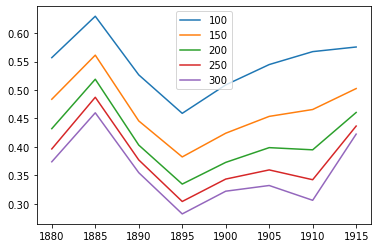

In [189]:
district_codes = pd.read_csv(data_dir / 'district_codes.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}

location_data = gpd.read_file(data_dir / 'intermediary' / 'plots_points_1878.shp')
location_data = split_plots(location_data, target_col='NUMBER')
location_data['district'] = [district_codes[int(d)] for d in location_data['DISTRICT']]
location_data['plot_number'] = [str(i) for i in location_data['NUMBER']]

results = {}
bws = 100, 150, 200, 250, 300

for year in range(1880, 1916, 5):
    s_ = []

    for bw in bws:

        population_data = pd.read_csv(data_dir / 'intermediary' / f'pop_by_page_{year}.csv').pipe(prepare_pop_data)

        data = get_aggregate_locations(
            population_data=population_data,
            location_data=location_data,
        )

        S = get_S(
            data=data,
            bandwidth=bw,
            cell_size=25,
            kernel_function=quartic_kernel,
        )

        s_.append(S.statistic)

    results[year] = s_

results = pd.DataFrame.from_dict(
    results,
    orient='index',
    columns=bws,
)
print(results)
results.plot()


# Results

Decrease until Russification
